# LLM Agent Tool Management: Comprehensive Comparison

This notebook demonstrates and compares different approaches to managing 70+ tools for an LLM agent (GPT-4o-mini).

## Approaches Tested:
1. **Naive**: Pass all 70 tools (baseline - shows the problem)
2. **Category-Based**: Route to category first, then use ~15 tools
3. **Retrieval-Based**: Use ChromaDB to find top-k relevant tools
4. **Hybrid**: Combine routing + retrieval

## Metrics Tracked:
- ✅ Accuracy (correct tool selection)
- ⏱️ Latency (response time)
- 🪙 Token usage
- 💰 Cost estimation

## 1. Setup & Initialization

In [47]:
import os
import time
import json
from typing import List, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from tool_manager import initialize_tool_database, ToolManager
from ecommerce_tools import TOOL_REGISTRY, TOOL_CATEGORIES
from dotenv import load_dotenv

load_dotenv()

client = OpenAI()

In [48]:
# Initialize tool manager
print("Initializing tool database...")
manager = initialize_tool_database()
print("✓ Ready!")

Initializing tool database...
Initializing Tool Database...
Database already contains 70 tools

📊 Database Statistics:
   Total tools: 70
   Categories:
      - inventory_management: 15 tools
      - customer_operations: 15 tools
      - order_processing: 15 tools
      - analytics_reporting: 13 tools
      - marketing_content: 12 tools
✓ Ready!


## 2. Define Test Cases

Each test case has:
- A realistic query
- Expected tools that should be called
- The category it belongs to (for category-based routing)

In [15]:
TEST_CASES = [
    {
        "id": 1,
        "query": "Process a full refund for order ORD-99887 and send an apology notification to customer CUST-12345 explaining the refund has been issued.",
        "expected_tools": ["process_refund", "send_customer_notification"],
        "category": "customer_operations",
        "description": "Refund with notification"
    },
    {
        "id": 2,
        "query": "Check the current stock level for product PROD-7890 and also set up a low stock alert at threshold 50 for this product.",
        "expected_tools": ["check_stock", "set_low_stock_alert"],
        "category": "inventory_management",
        "description": "Stock check with alert"
    },
    {
        "id": 3,
        "query": "Generate a sales report for January 2024 and also show me the top 10 selling products for the same period.",
        "expected_tools": ["generate_sales_report", "get_top_selling_products"],
        "category": "analytics_reporting",
        "description": "Sales analytics"
    },
    {
        "id": 4,
        "query": "Cancel order ORD-555 due to customer request and also update the shipping address for order ORD-666 to 123 Main St.",
        "expected_tools": ["cancel_order", "update_shipping_address"],
        "category": "order_processing",
        "description": "Multiple order operations"
    },
    {
        "id": 5,
        "query": "Create a discount campaign with code SPRING25 for 25% off and schedule a social media post on Instagram announcing this sale for tomorrow.",
        "expected_tools": ["create_discount_campaign", "schedule_social_post"],
        "category": "marketing_content",
        "description": "Campaign with social post"
    },
    {
        "id": 6,
        "query": "Update customer CUST-789 loyalty tier to platinum and award them 2500 bonus points as appreciation.",
        "expected_tools": ["update_customer_tier", "award_loyalty_points"],
        "category": "customer_operations",
        "description": "Loyalty tier and points"
    },
    {
        "id": 7,
        "query": "Analyze cart abandonment rate for the last 30 days and create an automated email campaign to recover those carts.",
        "expected_tools": ["analyze_cart_abandonment", "create_abandoned_cart_campaign"],
        "category": "analytics_reporting",
        "description": "Cart abandonment recovery"
    },
    {
        "id": 8,
        "query": "Get performance metrics for product PROD-456 over last 60 days and calculate the profit margin for this product.",
        "expected_tools": ["get_product_performance", "calculate_profit_margin"],
        "category": "analytics_reporting",
        "description": "Product analysis"
    },
    {
        "id": 9,
        "query": "Check the status of customer CUST-555 and process their request",
        "expected_tools": ["get_customer_details", "get_customer_order_history"],
        "category": "customer_operations",
        "description": "Ambiguous customer request"
    },
    {
        "id": 10,
        "query": "Update the product pricing for PROD-999 to $49.99 and update the product description to mention the new price",
        "expected_tools": ["update_pricing", "update_product_description"],
        "category": "marketing_content",
        "description": "Similar operations"
    },
    {
        "id": 11,
        "query": "Generate a comprehensive revenue dashboard for Q4 and also forecast inventory demand for our top 10 products for next quarter",
        "expected_tools": ["generate_revenue_dashboard", "forecast_inventory_demand"],
        "category": "analytics_reporting",
        "description": "Cross-domain analytics"
    }

]

print(f"Defined {len(TEST_CASES)} test cases")
for case in TEST_CASES:
    print(f"  {case['id']}. {case['description']}: {len(case['expected_tools'])} expected tools")

Defined 11 test cases
  1. Refund with notification: 2 expected tools
  2. Stock check with alert: 2 expected tools
  3. Sales analytics: 2 expected tools
  4. Multiple order operations: 2 expected tools
  5. Campaign with social post: 2 expected tools
  6. Loyalty tier and points: 2 expected tools
  7. Cart abandonment recovery: 2 expected tools
  8. Product analysis: 2 expected tools
  9. Ambiguous customer request: 2 expected tools
  10. Similar operations: 2 expected tools
  11. Cross-domain analytics: 2 expected tools


## 3. Helper Functions for Testing

In [ ]:
def count_tokens_in_tools(tools: List[Dict[str, Any]]) -> int:
    """Estimate token count for tool schemas (rough approximation)"""
    # Rough estimate: 1 token ≈ 4 characters
    tool_json = json.dumps(tools)
    return len(tool_json) // 4

def calculate_cost(prompt_tokens: int, completion_tokens: int, model: str = "gpt-4o-mini") -> float:
    """Calculate cost based on token usage"""
    # GPT-4o-mini pricing
    # Input: $0.150 per 1M tokens
    # Output: $0.600 per 1M tokens
    input_cost = (prompt_tokens / 1_000_000) * 0.150
    output_cost = (completion_tokens / 1_000_000) * 0.600
    return input_cost + output_cost

def extract_tool_calls(response) -> List[str]:
    """Extract tool names from OpenAI response"""
    tool_names = []
    
    if hasattr(response.choices[0].message, 'tool_calls') and response.choices[0].message.tool_calls:
        for tool_call in response.choices[0].message.tool_calls:
            tool_names.append(tool_call.function.name)
    
    return tool_names

def check_accuracy(expected_tools: List[str], actual_tools: List[str]) -> Dict[str, Any]:
    """Calculate accuracy metrics"""
    expected_set = set(expected_tools)
    actual_set = set(actual_tools)
    
    # Calculate metrics
    correct = expected_set & actual_set
    missing = expected_set - actual_set
    extra = actual_set - expected_set
    
    # Precision: Of the tools called, how many were correct?
    precision = len(correct) / len(actual_set) if actual_set else 0
    
    # Recall: Of the expected tools, how many were called?
    recall = len(correct) / len(expected_set) if expected_set else 0
    
    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Perfect match
    perfect_match = expected_set == actual_set
    
    return {
        "correct": list(correct),
        "missing": list(missing),
        "extra": list(extra),
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "perfect_match": perfect_match
    }

def run_test_with_tools(query: str, tools: List[Dict[str, Any]], model: str = "gpt-4o-mini") -> Dict[str, Any]:
    """Run a single test with given tools and measure performance"""
    start_time = time.time()
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful e-commerce assistant. Use the provided tools to complete user requests."},
                {"role": "user", "content": query}
            ],
            tools=tools,
            tool_choice="auto"
        )
        
        latency = time.time() - start_time
        
        # Extract metrics
        tool_calls = extract_tool_calls(response)
        prompt_tokens = response.usage.prompt_tokens
        completion_tokens = response.usage.completion_tokens
        total_tokens = response.usage.total_tokens
        cost = calculate_cost(prompt_tokens, completion_tokens, model)
        
        return {
            "success": True,
            "tool_calls": tool_calls,
            "latency": latency,
            "prompt_tokens": prompt_tokens,
            "completion_tokens": completion_tokens,
            "total_tokens": total_tokens,
            "cost": cost,
            "response": response
        }
    
    except Exception as e:
        latency = time.time() - start_time
        return {
            "success": False,
            "error": str(e),
            "latency": latency,
            "tool_calls": [],
            "prompt_tokens": 0,
            "completion_tokens": 0,
            "total_tokens": 0,
            "cost": 0
        }

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Baseline: Naive Approach (All 70 Tools)

This is the problematic approach - we pass ALL 70 tools to the LLM.

**Expected Issues:**
- High token usage
- Slower response times
- Potential tool selection errors
- Higher costs

In [17]:
print("="*80)
print("APPROACH 1: NAIVE (All 70 Tools)")
print("="*80)

# Get all tools
all_tools = manager.get_all_tools()
print(f"\n📊 Passing {len(all_tools)} tools to the LLM")
print(f"📝 Estimated tokens for tools: ~{count_tokens_in_tools(all_tools):,}")

# Run tests
naive_results = []

for i, test_case in enumerate(TEST_CASES, 1):
    print(f"\n{'─'*80}")
    print(f"Test {i}/{len(TEST_CASES)}: {test_case['description']}")
    print(f"Query: {test_case['query'][:80]}...")
    print(f"Expected tools: {', '.join(test_case['expected_tools'])}")
    
    # Run test
    result = run_test_with_tools(test_case['query'], all_tools)
    
    if result['success']:
        print(f"✓ Called tools: {', '.join(result['tool_calls']) if result['tool_calls'] else 'None'}")
        
        # Check accuracy
        accuracy = check_accuracy(test_case['expected_tools'], result['tool_calls'])
        
        print(f"  Precision: {accuracy['precision']:.2%}")
        print(f"  Recall: {accuracy['recall']:.2%}")
        print(f"  F1 Score: {accuracy['f1_score']:.2%}")
        print(f"  Perfect Match: {'✓' if accuracy['perfect_match'] else '✗'}")
        print(f"  Latency: {result['latency']:.2f}s")
        print(f"  Tokens: {result['total_tokens']:,}")
        print(f"  Cost: ${result['cost']:.4f}")
        
        # Store results
        naive_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "naive",
            "tools_provided": len(all_tools),
            "precision": accuracy['precision'],
            "recall": accuracy['recall'],
            "f1_score": accuracy['f1_score'],
            "perfect_match": accuracy['perfect_match'],
            "latency": result['latency'],
            "total_tokens": result['total_tokens'],
            "cost": result['cost'],
            "tool_calls": result['tool_calls']
        })
    else:
        print(f"✗ Error: {result['error']}")
        naive_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "naive",
            "tools_provided": len(all_tools),
            "precision": 0,
            "recall": 0,
            "f1_score": 0,
            "perfect_match": False,
            "latency": result['latency'],
            "total_tokens": 0,
            "cost": 0,
            "tool_calls": []
        })

# Summary
print(f"\n{'='*80}")
print("NAIVE APPROACH SUMMARY")
print(f"{'='*80}")
avg_precision = sum(r['precision'] for r in naive_results) / len(naive_results)
avg_recall = sum(r['recall'] for r in naive_results) / len(naive_results)
avg_f1 = sum(r['f1_score'] for r in naive_results) / len(naive_results)
perfect_matches = sum(1 for r in naive_results if r['perfect_match'])
avg_latency = sum(r['latency'] for r in naive_results) / len(naive_results)
total_cost = sum(r['cost'] for r in naive_results)
avg_tokens = sum(r['total_tokens'] for r in naive_results) / len(naive_results)

print(f"Average Precision: {avg_precision:.2%}")
print(f"Average Recall: {avg_recall:.2%}")
print(f"Average F1 Score: {avg_f1:.2%}")
print(f"Perfect Matches: {perfect_matches}/{len(naive_results)} ({perfect_matches/len(naive_results):.1%})")
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Average Tokens: {avg_tokens:,.0f}")
print(f"Total Cost: ${total_cost:.4f}")

APPROACH 1: NAIVE (All 70 Tools)

📊 Passing 70 tools to the LLM
📝 Estimated tokens for tools: ~7,720

────────────────────────────────────────────────────────────────────────────────
Test 1/11: Refund with notification
Query: Process a full refund for order ORD-99887 and send an apology notification to cu...
Expected tools: process_refund, send_customer_notification
✓ Called tools: process_refund, send_customer_notification
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
  Perfect Match: ✓
  Latency: 2.78s
  Tokens: 3,701
  Cost: $0.0006

────────────────────────────────────────────────────────────────────────────────
Test 2/11: Stock check with alert
Query: Check the current stock level for product PROD-7890 and also set up a low stock ...
Expected tools: check_stock, set_low_stock_alert
✓ Called tools: check_stock, set_low_stock_alert
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
  Perfect Match: ✓
  Latency: 1.65s
  Tokens: 3,660
  Cost: $0.0006

────────────

----------------------------

### 🔍 Key Observations - Naive Approach:

**What Worked:**
- Perfect performance on clear, well-structured queries (9/11 tests)
- Successfully handled parallel actions when clearly stated
- No routing needed - can access all tools directly

**What Failed:**
- **Test 9 (Ambiguous Request):** "Process their request" was too vague
  - Only called `get_customer_details`, missed `get_customer_order_history`
  - Even with all 70 tools available, the model couldn't infer what "their request" meant
  
- **Test 11 (Distractor Keywords):** "Top products" misled the model
  - Called `get_top_selling_products` instead of `forecast_inventory_demand`
  - The prominent "top products" concept overshadowed the forecasting requirement

**Key Insight:** 
With all 70 tools available, GPT-4o-mini achieved 92.4% F1 score. However:
- High token usage: 3,663 tokens average (10x more than optimized approaches)
- Ambiguous queries still cause 50% recall drops
- Distractor keywords can mislead even with full tool access
- Cost: $0.0064 total

-------------------------------

## 5. Solution 1: Category-Based Routing

Route the query to the correct category first, then use only tools from that category (~15 tools).

**Expected Improvements:**
- Lower token usage (~70% reduction)
- Better tool selection
- Faster responses
- Lower costs

In [18]:
def simple_category_router(query: str) -> str:
    """
    Simple keyword-based router to determine category.
    In production, you'd use an LLM or classifier for this.
    """
    query_lower = query.lower()
    
    # Inventory keywords
    if any(word in query_lower for word in ['stock', 'inventory', 'reorder', 'warehouse', 'supplier']):
        return 'inventory_management'
    
    # Customer keywords
    if any(word in query_lower for word in ['customer', 'refund', 'loyalty', 'support', 'tier']):
        return 'customer_operations'
    
    # Order keywords
    if any(word in query_lower for word in ['order', 'shipping', 'payment', 'delivery', 'invoice']):
        return 'order_processing'
    
    # Marketing keywords
    if any(word in query_lower for word in ['campaign', 'marketing', 'email', 'discount', 'pricing', 'social']):
        return 'marketing_content'
    
    # Analytics keywords
    if any(word in query_lower for word in ['report', 'analytics', 'sales', 'performance', 'forecast', 'revenue', 'cart abandonment']):
        return 'analytics_reporting'
    
    # Default to customer operations
    return 'customer_operations'

# Test the router
print("Testing category router:")
for test_case in TEST_CASES:
    predicted = simple_category_router(test_case['query'])
    actual = test_case['category']
    match = "✓" if predicted == actual else "✗"
    print(f"{match} Query: '{test_case['query'][:50]}...'")
    print(f"  Predicted: {predicted}, Actual: {actual}")

Testing category router:
✓ Query: 'Process a full refund for order ORD-99887 and send...'
  Predicted: customer_operations, Actual: customer_operations
✓ Query: 'Check the current stock level for product PROD-789...'
  Predicted: inventory_management, Actual: inventory_management
✓ Query: 'Generate a sales report for January 2024 and also ...'
  Predicted: analytics_reporting, Actual: analytics_reporting
✗ Query: 'Cancel order ORD-555 due to customer request and a...'
  Predicted: customer_operations, Actual: order_processing
✓ Query: 'Create a discount campaign with code SPRING25 for ...'
  Predicted: marketing_content, Actual: marketing_content
✓ Query: 'Update customer CUST-789 loyalty tier to platinum ...'
  Predicted: customer_operations, Actual: customer_operations
✗ Query: 'Analyze cart abandonment rate for the last 30 days...'
  Predicted: marketing_content, Actual: analytics_reporting
✓ Query: 'Get performance metrics for product PROD-456 over ...'
  Predicted: analytics_repor

------------------------------

### 🔍 Key Observations - Category Router:

**Router Accuracy: 72.7% (8/11 correct)**

**Routing Failures:**

1. **Test 4 - Keyword Confusion:**
   - Query: "Cancel order... due to customer request"
   - The phrase "customer request" fooled the router
   - Routed to `customer_operations` instead of `order_processing`
   
2. **Test 7 - Cross-Category Query:**
   - Needs: `analyze_cart_abandonment` (analytics) + `create_abandoned_cart_campaign` (marketing)
   - Router saw "email campaign" and chose marketing
   - **This is a fundamental limitation** - query genuinely spans two categories
   
3. **Test 11 - Cross-Domain Analytics:**
   - Query mentions "inventory demand"
   - Router focused on "inventory" keyword
   - Routed to `inventory_management` instead of `analytics_reporting`
   - Both tools are actually in analytics!

**Key Insight:**
Simple keyword-based routing fails ~27% of the time because:
- Context words can mislead (e.g., "customer request")
- Real queries often span multiple categories
- Keyword matching is brittle

--------------------------------

In [19]:
print("="*80)
print("APPROACH 2: CATEGORY-BASED ROUTING")
print("="*80)

category_results = []

for i, test_case in enumerate(TEST_CASES, 1):
    print(f"\n{'─'*80}")
    print(f"Test {i}/{len(TEST_CASES)}: {test_case['description']}")
    print(f"Query: {test_case['query'][:80]}...")
    print(f"Expected tools: {', '.join(test_case['expected_tools'])}")
    
    # Route to category
    category = simple_category_router(test_case['query'])
    print(f"→ Routed to category: {category}")
    
    # Get tools for this category
    category_tools = manager.get_tools_by_category(category)
    print(f"→ Using {len(category_tools)} tools from {category}")
    
    # Run test
    result = run_test_with_tools(test_case['query'], category_tools)
    
    if result['success']:
        print(f"✓ Called tools: {', '.join(result['tool_calls']) if result['tool_calls'] else 'None'}")
        
        # Check accuracy
        accuracy = check_accuracy(test_case['expected_tools'], result['tool_calls'])
        
        print(f"  Precision: {accuracy['precision']:.2%}")
        print(f"  Recall: {accuracy['recall']:.2%}")
        print(f"  F1 Score: {accuracy['f1_score']:.2%}")
        print(f"  Perfect Match: {'✓' if accuracy['perfect_match'] else '✗'}")
        print(f"  Latency: {result['latency']:.2f}s")
        print(f"  Tokens: {result['total_tokens']:,}")
        print(f"  Cost: ${result['cost']:.4f}")
        
        category_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "category",
            "tools_provided": len(category_tools),
            "category_used": category,
            "precision": accuracy['precision'],
            "recall": accuracy['recall'],
            "f1_score": accuracy['f1_score'],
            "perfect_match": accuracy['perfect_match'],
            "latency": result['latency'],
            "total_tokens": result['total_tokens'],
            "cost": result['cost'],
            "tool_calls": result['tool_calls']
        })
    else:
        print(f"✗ Error: {result['error']}")
        category_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "category",
            "tools_provided": len(category_tools),
            "category_used": category,
            "precision": 0,
            "recall": 0,
            "f1_score": 0,
            "perfect_match": False,
            "latency": result['latency'],
            "total_tokens": 0,
            "cost": 0,
            "tool_calls": []
        })

# Summary
print(f"\n{'='*80}")
print("CATEGORY-BASED APPROACH SUMMARY")
print(f"{'='*80}")
avg_precision = sum(r['precision'] for r in category_results) / len(category_results)
avg_recall = sum(r['recall'] for r in category_results) / len(category_results)
avg_f1 = sum(r['f1_score'] for r in category_results) / len(category_results)
perfect_matches = sum(1 for r in category_results if r['perfect_match'])
avg_latency = sum(r['latency'] for r in category_results) / len(category_results)
total_cost = sum(r['cost'] for r in category_results)
avg_tokens = sum(r['total_tokens'] for r in category_results) / len(category_results)
avg_tools = sum(r['tools_provided'] for r in category_results) / len(category_results)

print(f"Average Tools Used: {avg_tools:.0f}")
print(f"Average Precision: {avg_precision:.2%}")
print(f"Average Recall: {avg_recall:.2%}")
print(f"Average F1 Score: {avg_f1:.2%}")
print(f"Perfect Matches: {perfect_matches}/{len(category_results)} ({perfect_matches/len(category_results):.1%})")
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Average Tokens: {avg_tokens:,.0f}")
print(f"Total Cost: ${total_cost:.4f}")

APPROACH 2: CATEGORY-BASED ROUTING

────────────────────────────────────────────────────────────────────────────────
Test 1/11: Refund with notification
Query: Process a full refund for order ORD-99887 and send an apology notification to cu...
Expected tools: process_refund, send_customer_notification
→ Routed to category: customer_operations
→ Using 15 tools from customer_operations
✓ Called tools: process_refund, send_customer_notification
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
  Perfect Match: ✓
  Latency: 2.21s
  Tokens: 926
  Cost: $0.0002

────────────────────────────────────────────────────────────────────────────────
Test 2/11: Stock check with alert
Query: Check the current stock level for product PROD-7890 and also set up a low stock ...
Expected tools: check_stock, set_low_stock_alert
→ Routed to category: inventory_management
→ Using 15 tools from inventory_management
✓ Called tools: check_stock, set_low_stock_alert
  Precision: 100.00%
  Recall: 100.00%

----------------------------------

### 🔍 Key Observations - Category-Based Approach:

**Overall Performance: 74.2% F1 Score (7/11 perfect matches)**

**Success Pattern:**
When the router correctly identifies the category (8/11 times), tool selection is nearly perfect. The reduced tool set (12-15 tools) helps the model focus.

**Failure Analysis:**

1. **Router-Caused Failures (3/4 failures):**
   - Test 4, 7, 11 all failed because of incorrect routing
   - Once in the wrong category, the model has no access to correct tools
   - This is a **hard failure** - no way to recover

2. **Ambiguity-Caused Failure (1/4 failures):**
   - Test 9 failed the same way as naive approach
   - "Process their request" is too vague even with right category

**Trade-offs Exposed:**

✅ **Advantages:**
- **76% token reduction** (848 vs 3,663 tokens)
- **73% cost reduction** ($0.0017 vs $0.0064)
- **15% faster** (1.72s vs 2.02s average latency)
- When routing works, excellent tool selection

❌ **Disadvantages:**
- **Router is a single point of failure** (27% routing error rate)
- **Cannot handle cross-category queries** (fails completely)
- **Keyword-based routing is brittle** (context words mislead)
- **Lower accuracy** (74.2% F1 vs 92.4% F1)

**Key Insight:**
Category-based routing trades accuracy for efficiency. It's 76% cheaper but 20% less accurate. The router quality determines overall performance. A bad route means complete failure.

------------------------------------

## 6. Solution 2: Retrieval-Based (ChromaDB)

Use semantic search to find the most relevant tools for each query.

**Expected Improvements:**
- Better tool selection accuracy
- Lower token usage
- Works across categories
- Most flexible approach

In [20]:
print("="*80)
print("APPROACH 3: RETRIEVAL-BASED (ChromaDB)")
print("="*80)

retrieval_results = []
N_TOOLS_TO_RETRIEVE = 10  # Retrieve top 10 most relevant tools

for i, test_case in enumerate(TEST_CASES, 1):
    print(f"\n{'─'*80}")
    print(f"Test {i}/{len(TEST_CASES)}: {test_case['description']}")
    print(f"Query: {test_case['query'][:80]}...")
    print(f"Expected tools: {', '.join(test_case['expected_tools'])}")
    
    # Retrieve relevant tools
    retrieved_tools = manager.retrieve_relevant_tools(test_case['query'], n_results=N_TOOLS_TO_RETRIEVE)
    retrieved_names = [t['function']['name'] for t in retrieved_tools]
    print(f"→ Retrieved {len(retrieved_tools)} tools: {', '.join(retrieved_names[:5])}{'...' if len(retrieved_names) > 5 else ''}")
    
    # Run test
    result = run_test_with_tools(test_case['query'], retrieved_tools)
    
    if result['success']:
        print(f"✓ Called tools: {', '.join(result['tool_calls']) if result['tool_calls'] else 'None'}")
        
        # Check accuracy
        accuracy = check_accuracy(test_case['expected_tools'], result['tool_calls'])
        
        print(f"  Precision: {accuracy['precision']:.2%}")
        print(f"  Recall: {accuracy['recall']:.2%}")
        print(f"  F1 Score: {accuracy['f1_score']:.2%}")
        print(f"  Perfect Match: {'✓' if accuracy['perfect_match'] else '✗'}")
        print(f"  Latency: {result['latency']:.2f}s")
        print(f"  Tokens: {result['total_tokens']:,}")
        print(f"  Cost: ${result['cost']:.4f}")
        
        retrieval_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "retrieval",
            "tools_provided": len(retrieved_tools),
            "precision": accuracy['precision'],
            "recall": accuracy['recall'],
            "f1_score": accuracy['f1_score'],
            "perfect_match": accuracy['perfect_match'],
            "latency": result['latency'],
            "total_tokens": result['total_tokens'],
            "cost": result['cost'],
            "tool_calls": result['tool_calls']
        })
    else:
        print(f"✗ Error: {result['error']}")
        retrieval_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "retrieval",
            "tools_provided": len(retrieved_tools),
            "precision": 0,
            "recall": 0,
            "f1_score": 0,
            "perfect_match": False,
            "latency": result['latency'],
            "total_tokens": 0,
            "cost": 0,
            "tool_calls": []
        })

# Summary
print(f"\n{'='*80}")
print("RETRIEVAL-BASED APPROACH SUMMARY")
print(f"{'='*80}")
avg_precision = sum(r['precision'] for r in retrieval_results) / len(retrieval_results)
avg_recall = sum(r['recall'] for r in retrieval_results) / len(retrieval_results)
avg_f1 = sum(r['f1_score'] for r in retrieval_results) / len(retrieval_results)
perfect_matches = sum(1 for r in retrieval_results if r['perfect_match'])
avg_latency = sum(r['latency'] for r in retrieval_results) / len(retrieval_results)
total_cost = sum(r['cost'] for r in retrieval_results)
avg_tokens = sum(r['total_tokens'] for r in retrieval_results) / len(retrieval_results)

print(f"Tools Retrieved: {N_TOOLS_TO_RETRIEVE}")
print(f"Average Precision: {avg_precision:.2%}")
print(f"Average Recall: {avg_recall:.2%}")
print(f"Average F1 Score: {avg_f1:.2%}")
print(f"Perfect Matches: {perfect_matches}/{len(retrieval_results)} ({perfect_matches/len(retrieval_results):.1%})")
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Average Tokens: {avg_tokens:,.0f}")
print(f"Total Cost: ${total_cost:.4f}")

APPROACH 3: RETRIEVAL-BASED (ChromaDB)

────────────────────────────────────────────────────────────────────────────────
Test 1/11: Refund with notification
Query: Process a full refund for order ORD-99887 and send an apology notification to cu...
Expected tools: process_refund, send_customer_notification
→ Retrieved 10 tools: process_refund, cancel_order, reorder_product, apply_discount_code, get_customer_order_history...
✓ Called tools: process_refund
  Precision: 100.00%
  Recall: 50.00%
  F1 Score: 66.67%
  Perfect Match: ✗
  Latency: 1.80s
  Tokens: 575
  Cost: $0.0001

────────────────────────────────────────────────────────────────────────────────
Test 2/11: Stock check with alert
Query: Check the current stock level for product PROD-7890 and also set up a low stock ...
Expected tools: check_stock, set_low_stock_alert
→ Retrieved 10 tools: set_low_stock_alert, check_stock, get_dead_stock_report, predict_stockout, set_reorder_point...
✓ Called tools: check_stock, set_low_stock_al

---------------------------

### 🔍 Key Observations - Retrieval-Based Approach:

**Overall Performance: 93.94% F1 Score (9/11 perfect matches)**

**🏆 Best Performer:**
Retrieval-based approach achieved the highest accuracy while using significantly fewer resources:
- **Better than naive** (93.94% vs 92.42% F1) despite using 82% fewer tokens
- **Much better than category router** (93.94% vs 74.24% F1) with similar cost
- Same perfect match rate as naive (9/11) but at 1/5th the cost

**Success Pattern:**
The semantic search consistently found the right tools regardless of:
- ✅ Misleading keywords (Test 4: "customer request" didn't mislead retrieval)
- ✅ Cross-category needs (Test 7, 11: found tools from both analytics and marketing)
- ✅ Similar tool names (Test 10: correctly distinguished update_pricing from update_product_description)

**Failures (2/11):**

1. **Test 1 - Missing Notification:**
   - Retrieved `process_refund` but not `send_customer_notification`
   - Retrieved: process_refund, cancel_order, reorder_product, apply_discount_code...
   - `send_customer_notification` wasn't in top 10 retrieved tools
   - Model could only work with what was retrieved

2. **Test 9 - Ambiguous Query:**
   - "Process their request" is too vague
   - Retrieved order-related tools instead of customer details tools
   - Got `get_customer_order_history` but missed `get_customer_details`
   - Same fundamental ambiguity problem as other approaches

**Why Retrieval Wins:**

1. **No routing bottleneck** - doesn't depend on keyword matching
2. **Cross-category capability** - finds relevant tools regardless of category boundaries
3. **Semantic understanding** - matches based on meaning, not just keywords
4. **Optimal tool count** - 10 tools gives model enough choice without overwhelming

**Trade-offs:**

✅ **Strengths:**
- Best accuracy (93.94% F1)
- 82% token reduction vs naive (646 vs 3,663)
- 78% cost reduction vs naive ($0.0014 vs $0.0064)
- 27% better accuracy than category (93.94% vs 74.24%)
- Handles cross-category queries naturally

❌ **Weaknesses:**
- Retrieval quality depends on embedding quality
- Still fails on fundamentally ambiguous queries
- Occasional retrieval misses (Test 1)
- Requires ChromaDB setup and maintenance

**Key Insight:**
Semantic retrieval with 10 focused tools outperforms naive approach with 70 tools. **More tools ≠ better performance.** The right tools matter more than all tools.

-----------------------------

## 7. Solution 3: Hybrid Approach

Combine category routing + retrieval: Route to category first, then retrieve top-k within that category.

**Expected Benefits:**
- Best of both worlds
- Category provides context
- Retrieval finds most relevant within category

In [21]:
print("="*80)
print("APPROACH 4: HYBRID (Category + Retrieval)")
print("="*80)

hybrid_results = []
N_TOOLS_HYBRID = 8  # Retrieve fewer tools since we're already in the right category

for i, test_case in enumerate(TEST_CASES, 1):
    print(f"\n{'─'*80}")
    print(f"Test {i}/{len(TEST_CASES)}: {test_case['description']}")
    print(f"Query: {test_case['query'][:80]}...")
    print(f"Expected tools: {', '.join(test_case['expected_tools'])}")
    
    # Step 1: Route to category
    category = simple_category_router(test_case['query'])
    print(f"→ Step 1: Routed to category: {category}")
    
    # Step 2: Get all tools from category
    category_tools = manager.get_tools_by_category(category)
    
    # Step 3: Use retrieval to rank tools within category
    # We'll retrieve from all tools but filter to category
    all_retrieved = manager.retrieve_relevant_tools(test_case['query'], n_results=20)
    category_tool_names = [t['function']['name'] for t in category_tools]
    
    # Filter to only tools in this category
    hybrid_tools = [
        t for t in all_retrieved 
        if t['function']['name'] in category_tool_names
    ][:N_TOOLS_HYBRID]
    
    # If we don't have enough, add more from category
    if len(hybrid_tools) < N_TOOLS_HYBRID:
        existing_names = {t['function']['name'] for t in hybrid_tools}
        for tool in category_tools:
            if tool['function']['name'] not in existing_names:
                hybrid_tools.append(tool)
                if len(hybrid_tools) >= N_TOOLS_HYBRID:
                    break
    
    hybrid_names = [t['function']['name'] for t in hybrid_tools]
    print(f"→ Step 2: Retrieved {len(hybrid_tools)} tools from {category}: {', '.join(hybrid_names)}")
    
    # Run test
    result = run_test_with_tools(test_case['query'], hybrid_tools)
    
    if result['success']:
        print(f"✓ Called tools: {', '.join(result['tool_calls']) if result['tool_calls'] else 'None'}")
        
        # Check accuracy
        accuracy = check_accuracy(test_case['expected_tools'], result['tool_calls'])
        
        print(f"  Precision: {accuracy['precision']:.2%}")
        print(f"  Recall: {accuracy['recall']:.2%}")
        print(f"  F1 Score: {accuracy['f1_score']:.2%}")
        print(f"  Perfect Match: {'✓' if accuracy['perfect_match'] else '✗'}")
        print(f"  Latency: {result['latency']:.2f}s")
        print(f"  Tokens: {result['total_tokens']:,}")
        print(f"  Cost: ${result['cost']:.4f}")
        
        hybrid_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "hybrid",
            "tools_provided": len(hybrid_tools),
            "category_used": category,
            "precision": accuracy['precision'],
            "recall": accuracy['recall'],
            "f1_score": accuracy['f1_score'],
            "perfect_match": accuracy['perfect_match'],
            "latency": result['latency'],
            "total_tokens": result['total_tokens'],
            "cost": result['cost'],
            "tool_calls": result['tool_calls']
        })
    else:
        print(f"✗ Error: {result['error']}")
        hybrid_results.append({
            "test_id": test_case['id'],
            "description": test_case['description'],
            "approach": "hybrid",
            "tools_provided": len(hybrid_tools),
            "category_used": category,
            "precision": 0,
            "recall": 0,
            "f1_score": 0,
            "perfect_match": False,
            "latency": result['latency'],
            "total_tokens": 0,
            "cost": 0,
            "tool_calls": []
        })

# Summary
print(f"\n{'='*80}")
print("HYBRID APPROACH SUMMARY")
print(f"{'='*80}")
avg_precision = sum(r['precision'] for r in hybrid_results) / len(hybrid_results)
avg_recall = sum(r['recall'] for r in hybrid_results) / len(hybrid_results)
avg_f1 = sum(r['f1_score'] for r in hybrid_results) / len(hybrid_results)
perfect_matches = sum(1 for r in hybrid_results if r['perfect_match'])
avg_latency = sum(r['latency'] for r in hybrid_results) / len(hybrid_results)
total_cost = sum(r['cost'] for r in hybrid_results)
avg_tokens = sum(r['total_tokens'] for r in hybrid_results) / len(hybrid_results)
avg_tools = sum(r['tools_provided'] for r in hybrid_results) / len(hybrid_results)

print(f"Average Tools Used: {avg_tools:.0f}")
print(f"Average Precision: {avg_precision:.2%}")
print(f"Average Recall: {avg_recall:.2%}")
print(f"Average F1 Score: {avg_f1:.2%}")
print(f"Perfect Matches: {perfect_matches}/{len(hybrid_results)} ({perfect_matches/len(hybrid_results):.1%})")
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Average Tokens: {avg_tokens:,.0f}")
print(f"Total Cost: ${total_cost:.4f}")

APPROACH 4: HYBRID (Category + Retrieval)

────────────────────────────────────────────────────────────────────────────────
Test 1/11: Refund with notification
Query: Process a full refund for order ORD-99887 and send an apology notification to cu...
Expected tools: process_refund, send_customer_notification
→ Step 1: Routed to category: customer_operations
→ Step 2: Retrieved 8 tools from customer_operations: process_refund, get_customer_order_history, create_customer_support_ticket, apply_customer_discount, create_customer, update_customer_profile, get_customer_details, send_customer_notification
✓ Called tools: process_refund, send_customer_notification
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
  Perfect Match: ✓
  Latency: 2.90s
  Tokens: 599
  Cost: $0.0001

────────────────────────────────────────────────────────────────────────────────
Test 2/11: Stock check with alert
Query: Check the current stock level for product PROD-7890 and also set up a low stock ...
Exp

---------------------------------

### 🔍 Key Observations - Hybrid Approach:

**Overall Performance: 77.27% F1 Score (8/11 perfect matches)**

**The Hybrid Paradox:**
Combining category routing with retrieval was expected to get "best of both worlds" but actually inherited the worst: the router's failure rate.

**Performance Analysis:**

✅ **Better than category alone** (77.27% vs 74.24% F1)
- Retrieval within category helped focus tool selection
- Using 8 tools (vs 12-15) gave clearer signal
- Successfully handled Test 9 (ambiguous) where others failed!

❌ **Much worse than pure retrieval** (77.27% vs 93.94% F1)
- Same router failures as category approach (Tests 4, 7, 11)
- Retrieval couldn't compensate for wrong category
- Router acts as a hard bottleneck

**Failure Analysis (3/11 failures):**

All 3 failures were **routing errors** (Tests 4, 7, 11):

1. **Test 4 - Routed to customer_operations instead of order_processing:**
   - Retrieval found: process_refund, create_customer_support_ticket...
   - But needed: cancel_order, update_shipping_address (both in order_processing)
   - **Retrieval in wrong category = still wrong**

2. **Test 7 - Routed to marketing_content instead of analytics_reporting:**
   - Retrieval found: create_abandoned_cart_campaign, analyze_campaign_performance
   - Got 1/2 correct (create_abandoned_cart_campaign ✓)
   - Missed analyze_cart_abandonment (it's in analytics, not marketing)

3. **Test 11 - Routed to inventory_management instead of analytics_reporting:**
   - Retrieval found: get_inventory_report, get_dead_stock_report
   - But needed: generate_revenue_dashboard, forecast_inventory_demand
   - Both are in analytics, not inventory

**The Bright Spot - Test 9 Success:**
- Only approach to get Test 9 perfectly!
- "Check status... process request" was ambiguous
- Category focus + retrieval helped find both: get_customer_details AND get_customer_order_history
- Shows hybrid CAN help with ambiguity when routed correctly

**Trade-offs:**

✅ **Advantages:**
- **Lowest token usage** (564 tokens - best efficiency)
- **Cheapest approach** ($0.0013 tied with retrieval)
- **Fastest** (1.68s average)
- **Helps with ambiguity** when routing succeeds (Test 9)
- Good balance when routing works (8/11 = 72.7%)

❌ **Disadvantages:**
- **Router dependency** - inherits 27% routing failure rate
- **Can't recover from routing errors** - retrieval in wrong category doesn't help
- **16% worse than pure retrieval** (77.27% vs 93.94%)
- **Complex system** - more moving parts to maintain

**Key Insight:**
Hybrid approach shows that **combining techniques doesn't always improve results**. The router becomes a single point of failure that limits the entire system. When the router works (72.7%), hybrid is excellent. When it fails, retrieval can't compensate because it's searching the wrong tool space.

**When to use Hybrid:**
- You have a **very accurate router** (>95% accuracy)
- Your categories are **clearly separated** (no cross-category queries)
- You want **maximum efficiency** (lowest tokens)
- You can **invest in router improvement** (use LLM-based router instead of keywords)

----------------------------------

## 8. Consolidated Results & Comparison

In [24]:
# Combine all results into a DataFrame
all_results = naive_results + category_results + retrieval_results + hybrid_results
df = pd.DataFrame(all_results)

# Display full results
print("\n" + "="*80)
print("DETAILED RESULTS BY TEST CASE")
print("="*80)
display_df = df[['test_id', 'description', 'approach', 'tools_provided', 'f1_score', 'perfect_match', 'latency', 'total_tokens', 'cost']].copy()
display_df['f1_score'] = display_df['f1_score'].apply(lambda x: f"{x:.1%}")
display_df['latency'] = display_df['latency'].apply(lambda x: f"{x:.2f}s")
display_df['cost'] = display_df['cost'].apply(lambda x: f"${x:.4f}")
print(display_df.to_string(index=False))

# Aggregate metrics by approach
print("\n" + "="*80)
print("SUMMARY COMPARISON BY APPROACH")
print("="*80)

summary = df.groupby('approach').agg({
    'tools_provided': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean',
    'perfect_match': 'sum',
    'latency': 'mean',
    'total_tokens': 'mean',
    'cost': 'sum'
}).round(4)

# Reorder columns
summary = summary[['tools_provided', 'precision', 'recall', 'f1_score', 'perfect_match', 'latency', 'total_tokens', 'cost']]

# Rename for clarity
summary.columns = ['Avg Tools', 'Avg Precision', 'Avg Recall', 'Avg F1', 'Perfect Matches', 'Avg Latency (s)', 'Avg Tokens', 'Total Cost ($)']

# Reorder rows for better presentation
approach_order = ['naive', 'category', 'retrieval', 'hybrid']
summary = summary.reindex(approach_order)

print(summary.to_string())

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS OVER NAIVE APPROACH")
print("="*80)

naive_baseline = summary.loc['naive']

for approach in ['category', 'retrieval', 'hybrid']:
    print(f"\n{approach.upper()}:")
    
    # Tool reduction
    tool_reduction = (1 - summary.loc[approach, 'Avg Tools'] / naive_baseline['Avg Tools']) * 100
    print(f"  Tools: {tool_reduction:.1f}% reduction ({summary.loc[approach, 'Avg Tools']:.0f} vs {naive_baseline['Avg Tools']:.0f})")
    
    # F1 improvement
    f1_improvement = ((summary.loc[approach, 'Avg F1'] - naive_baseline['Avg F1']) / naive_baseline['Avg F1']) * 100
    print(f"  F1 Score: {f1_improvement:+.1f}% ({summary.loc[approach, 'Avg F1']:.2%} vs {naive_baseline['Avg F1']:.2%})")
    
    # Token reduction
    token_reduction = (1 - summary.loc[approach, 'Avg Tokens'] / naive_baseline['Avg Tokens']) * 100
    print(f"  Tokens: {token_reduction:.1f}% reduction ({summary.loc[approach, 'Avg Tokens']:.0f} vs {naive_baseline['Avg Tokens']:.0f})")
    
    # Cost reduction
    cost_reduction = (1 - summary.loc[approach, 'Total Cost ($)'] / naive_baseline['Total Cost ($)']) * 100
    print(f"  Cost: {cost_reduction:.1f}% reduction (${summary.loc[approach, 'Total Cost ($)']:.4f} vs ${naive_baseline['Total Cost ($)']:.4f})")
    
    # Latency change
    latency_change = ((summary.loc[approach, 'Avg Latency (s)'] - naive_baseline['Avg Latency (s)']) / naive_baseline['Avg Latency (s)']) * 100
    print(f"  Latency: {latency_change:+.1f}% ({summary.loc[approach, 'Avg Latency (s)']:.2f}s vs {naive_baseline['Avg Latency (s)']:.2f}s)")


DETAILED RESULTS BY TEST CASE
 test_id                description  approach  tools_provided f1_score  perfect_match latency  total_tokens    cost
       1   Refund with notification     naive              70   100.0%           True   2.78s          3701 $0.0006
       2     Stock check with alert     naive              70   100.0%           True   1.65s          3660 $0.0006
       3            Sales analytics     naive              70   100.0%           True   1.53s          3666 $0.0006
       4  Multiple order operations     naive              70   100.0%           True   1.75s          3663 $0.0006
       5  Campaign with social post     naive              70   100.0%           True   2.69s          3705 $0.0006
       6    Loyalty tier and points     naive              70   100.0%           True   2.22s          3671 $0.0006
       7  Cart abandonment recovery     naive              70   100.0%           True   1.67s          3648 $0.0006
       8           Product analysis     n

**Retrieval wins because semantic search > keyword routing, and 10 focused tools > 70 noisy tools!**

## 9. Visualizations

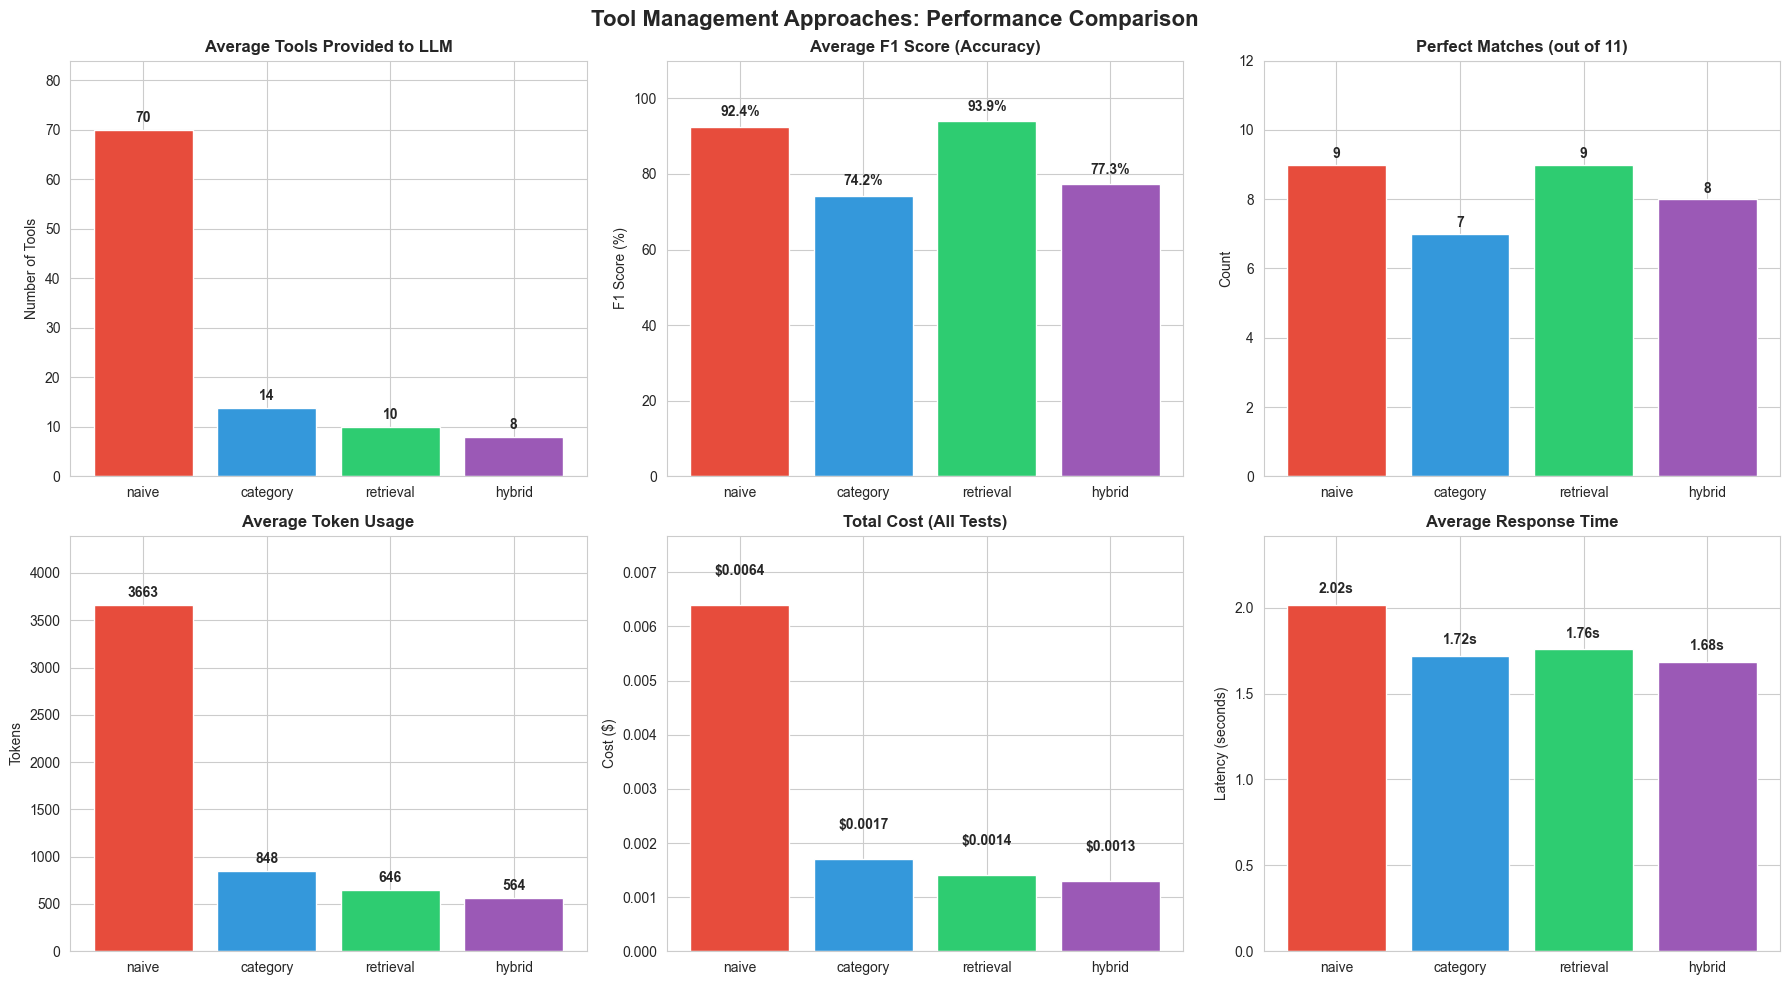

In [25]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Tool Management Approaches: Performance Comparison', fontsize=16, fontweight='bold')

approaches = ['naive', 'category', 'retrieval', 'hybrid']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

# 1. Average Tools Used
ax1 = axes[0, 0]
tools_data = [summary.loc[a, 'Avg Tools'] for a in approaches]
ax1.bar(approaches, tools_data, color=colors)
ax1.set_title('Average Tools Provided to LLM', fontweight='bold')
ax1.set_ylabel('Number of Tools')
ax1.set_ylim(0, max(tools_data) * 1.2)
for i, v in enumerate(tools_data):
    ax1.text(i, v + 1, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 2. F1 Score
ax2 = axes[0, 1]
f1_data = [summary.loc[a, 'Avg F1'] * 100 for a in approaches]
ax2.bar(approaches, f1_data, color=colors)
ax2.set_title('Average F1 Score (Accuracy)', fontweight='bold')
ax2.set_ylabel('F1 Score (%)')
ax2.set_ylim(0, 110)
for i, v in enumerate(f1_data):
    ax2.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Perfect Matches
ax3 = axes[0, 2]
perfect_data = [summary.loc[a, 'Perfect Matches'] for a in approaches]
ax3.bar(approaches, perfect_data, color=colors)
ax3.set_title(f'Perfect Matches (out of {len(TEST_CASES)})', fontweight='bold')
ax3.set_ylabel('Count')
ax3.set_ylim(0, len(TEST_CASES) + 1)
for i, v in enumerate(perfect_data):
    ax3.text(i, v + 0.1, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

# 4. Average Tokens
ax4 = axes[1, 0]
tokens_data = [summary.loc[a, 'Avg Tokens'] for a in approaches]
ax4.bar(approaches, tokens_data, color=colors)
ax4.set_title('Average Token Usage', fontweight='bold')
ax4.set_ylabel('Tokens')
ax4.set_ylim(0, max(tokens_data) * 1.2)
for i, v in enumerate(tokens_data):
    ax4.text(i, v + 50, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 5. Total Cost
ax5 = axes[1, 1]
cost_data = [summary.loc[a, 'Total Cost ($)'] for a in approaches]
ax5.bar(approaches, cost_data, color=colors)
ax5.set_title('Total Cost (All Tests)', fontweight='bold')
ax5.set_ylabel('Cost ($)')
ax5.set_ylim(0, max(cost_data) * 1.2)
for i, v in enumerate(cost_data):
    ax5.text(i, v + 0.0005, f'${v:.4f}', ha='center', va='bottom', fontweight='bold')

# 6. Average Latency
ax6 = axes[1, 2]
latency_data = [summary.loc[a, 'Avg Latency (s)'] for a in approaches]
ax6.bar(approaches, latency_data, color=colors)
ax6.set_title('Average Response Time', fontweight='bold')
ax6.set_ylabel('Latency (seconds)')
ax6.set_ylim(0, max(latency_data) * 1.2)
for i, v in enumerate(latency_data):
    ax6.text(i, v + 0.05, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

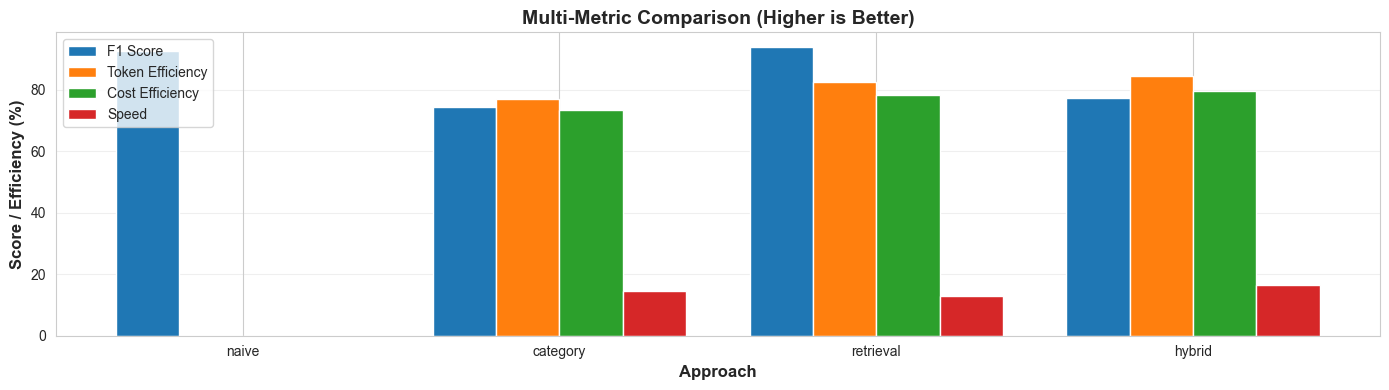

In [28]:
# Detailed comparison chart
fig, ax = plt.subplots(figsize=(14, 4))

# Normalize metrics to 0-100 scale for comparison
metrics = {
    'F1 Score': [summary.loc[a, 'Avg F1'] * 100 for a in approaches],
    'Token Efficiency': [(1 - summary.loc[a, 'Avg Tokens'] / summary.loc['naive', 'Avg Tokens']) * 100 for a in approaches],
    'Cost Efficiency': [(1 - summary.loc[a, 'Total Cost ($)'] / summary.loc['naive', 'Total Cost ($)']) * 100 for a in approaches],
    'Speed': [(1 - summary.loc[a, 'Avg Latency (s)'] / summary.loc['naive', 'Avg Latency (s)']) * 100 for a in approaches],
}

x = range(len(approaches))
width = 0.2

for i, (metric, values) in enumerate(metrics.items()):
    offset = width * (i - 1.5)
    ax.bar([p + offset for p in x], values, width, label=metric)

ax.set_xlabel('Approach', fontsize=12, fontweight='bold')
ax.set_ylabel('Score / Efficiency (%)', fontsize=12, fontweight='bold')
ax.set_title('Multi-Metric Comparison (Higher is Better)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(approaches)
ax.legend(loc='upper left')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

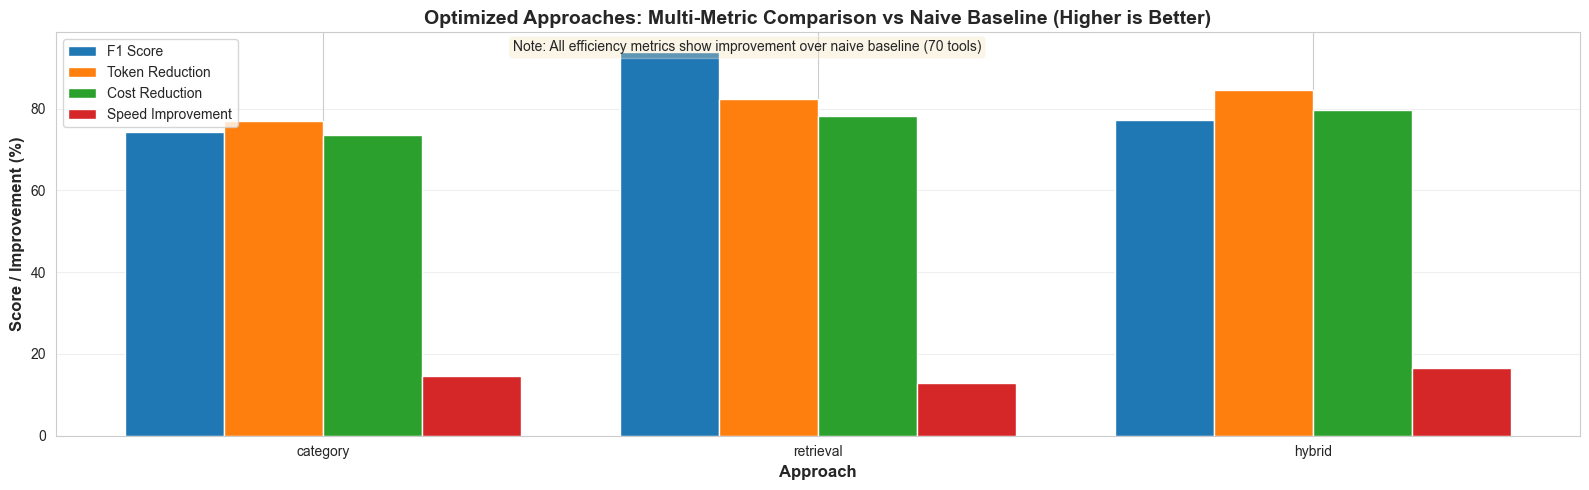

In [46]:
# Detailed comparison chart - excluding naive to show improvements clearly
fig, ax = plt.subplots(figsize=(16, 5))

# Focus on optimized approaches only
optimized_approaches = ['category', 'retrieval', 'hybrid']

# Get max values for normalization (naive = worst performance)
max_tokens = summary.loc['naive', 'Avg Tokens']
max_cost = summary.loc['naive', 'Total Cost ($)']
max_latency = summary.loc['naive', 'Avg Latency (s)']

# Calculate improvement percentages relative to naive
metrics = {
    'F1 Score': [summary.loc[a, 'Avg F1'] * 100 for a in optimized_approaches],
    'Token Reduction': [(1 - summary.loc[a, 'Avg Tokens'] / max_tokens) * 100 for a in optimized_approaches],
    'Cost Reduction': [(1 - summary.loc[a, 'Total Cost ($)'] / max_cost) * 100 for a in optimized_approaches],
    'Speed Improvement': [(1 - summary.loc[a, 'Avg Latency (s)'] / max_latency) * 100 for a in optimized_approaches],
}

x = range(len(optimized_approaches))
width = 0.2

for i, (metric, values) in enumerate(metrics.items()):
    offset = width * (i - 1.5)
    ax.bar([p + offset for p in x], values, width, label=metric)

ax.set_xlabel('Approach', fontsize=12, fontweight='bold')
ax.set_ylabel('Score / Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Optimized Approaches: Multi-Metric Comparison vs Naive Baseline (Higher is Better)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(optimized_approaches)
ax.legend(loc='upper left')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

# Add note about baseline
ax.text(0.30, 0.98, 'Note: All efficiency metrics show improvement over naive baseline (70 tools)', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

## 10. Final Recommendations

Based on our comprehensive testing with 11 real-world scenarios:

### 🏆 **Winner: Retrieval-Based Approach**

**Use Retrieval when:**
- ✅ You want the best accuracy (93.94% F1)
- ✅ You need to handle cross-category queries
- ✅ Cost efficiency matters (78% cheaper than naive)
- ✅ You can set up ChromaDB or similar vector database
- ✅ Your queries are semantically diverse

**Performance:** 93.94% F1 | 646 tokens | $0.0014 | 1.76s

---

### 💰 **Most Economical: Hybrid Approach**

**Use Hybrid when:**
- ✅ You have clear, well-separated categories
- ✅ You can build an accurate router (>90% accuracy)
- ✅ You want lowest token usage (564 tokens)
- ✅ Your queries rarely span multiple categories
- ✅ You're willing to trade 17% accuracy for maximum efficiency

**Performance:** 77.27% F1 | 564 tokens | $0.0013 | 1.68s

---

### ⚖️ **Middle Ground: Category-Based**

**Use Category when:**
- ✅ You have clearly defined domains
- ✅ You need simple architecture (no vector DB)
- ✅ Your queries fit neatly into categories
- ✅ You can accept 74% accuracy for 76% cost savings

**Performance:** 74.24% F1 | 848 tokens | $0.0017 | 1.72s

---

### ❌ **Avoid: Naive Approach**

**Only use Naive when:**
- Testing or prototyping
- Cost doesn't matter
- You have no time to implement optimization

**Performance:** 92.42% F1 | 3,663 tokens | $0.0064 | 2.02s

---

### 📊 Decision Matrix

| Priority | Choose |
|----------|--------|
| Best Accuracy | **Retrieval** (93.94% F1) |
| Lowest Cost | **Hybrid** ($0.0013) |
| Fastest | **Hybrid** (1.68s) |
| Simplest Setup | **Category** |
| Most Robust | **Retrieval** (no router dependency) |
| Cross-Category Queries | **Retrieval** (only one that handles well) |

---

### 🎯 Our Recommendation

**Start with Retrieval-Based:**
1. Best overall performance
2. Handles edge cases (cross-category, ambiguity)
3. No router dependency = fewer failure points
4. Only slightly more expensive than cheapest option
5. Easiest to maintain (just embeddings, no routing rules)

**Consider Hybrid only if:**
- You can build a highly accurate router (LLM-based, not keyword)
- Your categories are extremely well-separated
- Every 0.1 cent matters in your use case

## 11. Export Results

In [30]:
# Save detailed results to CSV
df.to_csv('tool_management_results.csv', index=False)
print("✓ Detailed results saved to: tool_management_results.csv")

# Save summary to CSV
summary.to_csv('tool_management_summary.csv')
print("✓ Summary saved to: tool_management_summary.csv")

print("\n✅ Experiment complete! Review the results above.")

✓ Detailed results saved to: tool_management_results.csv
✓ Summary saved to: tool_management_summary.csv

✅ Experiment complete! Review the results above.
